In [1]:
import cv2
import os
import mediapipe as mp
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split


In [2]:
video_path = "C:\\Users\\hrush\\OneDrive\\Desktop\\epic kitchen p01_01.mp4"

In [3]:
cap = cv2.VideoCapture(video_path) #initializing the connection to video file
ret, frame = cap.read()
print(frame.shape)
print(f"Resolution: {frame.shape[1]}x{frame.shape[0]}")
print(f"Total Frames: {int(cap.get(cv2.CAP_PROP_FRAME_COUNT))}")
cap.release()

(720, 1280, 3)
Resolution: 1280x720
Total Frames: 21770


In [4]:
# read csv
df = pd.read_csv("C:\\Users\\hrush\\Downloads\\EPIC_100_uda_source_train.csv")

# use only one video
df = df[df["video_id"] == "P01_01"]
df = df.iloc[:150]


In [5]:
# output folder
output = "C:\\Users\\hrush\\OneDrive\\Desktop\\dataframes"
os.makedirs(output, exist_ok=True)

# time gap between frames
deltas = [5,10]
# open video
cap = cv2.VideoCapture(video_path)

# take multiple samples from each action segment
offsets = [0, 6, 12, 18, 24,30,36,42]   

count = 0

for idx, row in df.iterrows():
    start = int(row["start_frame"])
    stop = int(row["stop_frame"])

    for k, off in enumerate(offsets):
        t = start + off
        for delta in deltas:
            # make sure we don't go past the action
            if t + delta >= stop:
                continue
                
            cap.set(cv2.CAP_PROP_POS_FRAMES, t)
            ret1, frame_t = cap.read()

            cap.set(cv2.CAP_PROP_POS_FRAMES, t + delta)
            ret2, frame_t2 = cap.read()

            if ret1 and ret2:
                cv2.imwrite(f"{output}\\{idx}_{k}_t.jpg", frame_t)
                cv2.imwrite(f"{output}\\{idx}_{k}_t2.jpg", frame_t2)
                count += 1

cap.release()

print("Total frame pairs extracted:", count)


Total frame pairs extracted: 261


In [6]:
frame_dir = r"C:\Users\hrush\OneDrive\Desktop\dataframes"
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.3
)



In [7]:
#creating a helper function
def get_wrist(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    res = hands.process(img_rgb)

    if not res.multi_hand_landmarks:
        return None

    wrist = res.multi_hand_landmarks[0].landmark[0]
    return np.array([wrist.x, wrist.y])

In [8]:
samples = []

for f in os.listdir(frame_dir):
    if not f.endswith("_t.jpg"):
        continue

    f2 = f.replace("_t.jpg", "_t2.jpg")
    path1 = os.path.join(frame_dir, f)
    path2 = os.path.join(frame_dir, f2)

    if not os.path.exists(path2):
        continue

    img1 = cv2.imread(path1)
    img2 = cv2.imread(path2)

    p1 = get_wrist(img1)
    p2 = get_wrist(img2)

    if p1 is None or p2 is None:
        continue

    dx, dy = p2 - p1
    samples.append([f, f2, float(dx), float(dy)])
df_pseudo = pd.DataFrame(
    samples,
    columns=["img_t", "img_t2", "dx", "dy"]
)

print("Total valid pseudo-action pairs:", len(samples))

Total valid pseudo-action pairs: 51


In [9]:
df_pseudo.head()

,img_t,img_t2,dx,dy
0,100_0_t.jpg,100_0_t2.jpg,-0.307908,-0.111797
1,100_1_t.jpg,100_1_t2.jpg,-0.019611,-0.011224
2,100_2_t.jpg,100_2_t2.jpg,0.010096,0.002615
3,100_3_t.jpg,100_3_t2.jpg,0.003344,-0.014618
4,100_4_t.jpg,100_4_t2.jpg,-0.002150,-0.007294


### Creating Train Test Split 

In [11]:
df_train,df_test = train_test_split(df_pseudo,test_size= 0.2,random_state=42)
print("Train samples:", len(df_train))
print("Test samples :", len(df_test))


Train samples: 40
Test samples : 11


## Inverse Dynamic Model (CNN)

In [13]:
#creating a function to load an image pair that is action 
def load_image_pair(row, size=(128, 128)):
    img1 = cv2.imread(os.path.join(frame_dir, row["img_t"]))
    img2 = cv2.imread(os.path.join(frame_dir, row["img_t2"]))

    img1 = cv2.resize(img1, size)
    img2 = cv2.resize(img2, size)

    img1 = img1.astype(np.float32) / 255.0
    img2 = img2.astype(np.float32) / 255.0

    # stack along channel dimension
    return np.concatenate([img1, img2], axis=2)


In [14]:
# build train set and converting numpy to tensor
X_train, y_train = [], []

for _, row in df_train.iterrows():
    X_train.append(load_image_pair(row))
    y_train.append([row["dx"], row["dy"]])

X_train = torch.tensor(np.array(X_train)).permute(0, 3, 1, 2).float()
y_train = torch.tensor(np.array(y_train)).float()

# build test set and converting numpy to tensor
X_test, y_test = [], []

for _, row in df_test.iterrows():
    X_test.append(load_image_pair(row))
    y_test.append([row["dx"], row["dy"]])

X_test = torch.tensor(np.array(X_test)).permute(0, 3, 1, 2).float()
y_test = torch.tensor(np.array(y_test)).float()

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test :", X_test.shape)
print("y_test :", y_test.shape)

X_train: torch.Size([40, 6, 128, 128])
y_train: torch.Size([40, 2])
X_test : torch.Size([11, 6, 128, 128])
y_test : torch.Size([11, 2])


### Inverse Dynamic Model

In [16]:
class InverseDynamicsModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # Δx, Δy
        )

    def forward(self, x):
        x = self.features(x)
        x = self.head(x)
        return x

In [17]:
model = InverseDynamicsModel()
print(model)

InverseDynamicsModel(
  (features): Sequential(
    (0): Conv2d(6, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (head): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)


#### Baseline Test before training without learning and checking the model predictions 

In [19]:
criterion = nn.MSELoss()
with torch.no_grad():
    train_preds_before = model(X_train)
    test_preds_before = model(X_test)

train_loss_before = criterion(train_preds_before, y_train).item()
test_loss_before = criterion(test_preds_before, y_test).item()

print("Train loss BEFORE training:", round(train_loss_before,4))
print("Test loss  BEFORE training:", round(test_loss_before,4))

Train loss BEFORE training: 0.0137
Test loss  BEFORE training: 0.0093


#### Training the model

In [21]:
# loss function 
criterion = nn.MSELoss()
#we used Adam optimization algorithm for stable and fast convergence
optimizer = optim.Adam(model.parameters(),lr=1e-3)
epochs = 50
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    # Training the model on training set
    # forward pass
    preds_train = model(X_train)
    # compute loss
    train_loss = criterion(preds_train, y_train)
    # backward pass
    train_loss.backward()
    optimizer.step()
    # Evaluating model on testset
    model.eval()
    with torch.no_grad():
        preds_test = model(X_test)
        test_loss = criterion(preds_test, y_test)

    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())

    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch {epoch+1:02d} | "
            f"Train Loss: {train_loss.item():.5f} | "
            f"Test Loss: {test_loss.item():.5f}"
        )

Epoch 10 | Train Loss: 0.01174 | Test Loss: 0.01223
Epoch 20 | Train Loss: 0.01020 | Test Loss: 0.01232
Epoch 30 | Train Loss: 0.00670 | Test Loss: 0.01678
Epoch 40 | Train Loss: 0.00264 | Test Loss: 0.01723
Epoch 50 | Train Loss: 0.00101 | Test Loss: 0.01768


#### Loss Curve

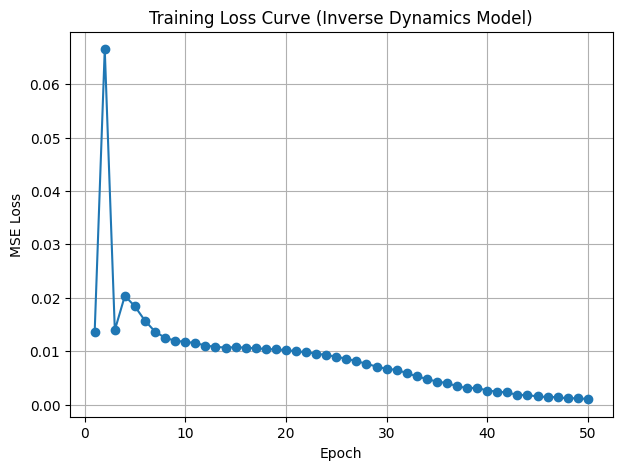

In [23]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve (Inverse Dynamics Model)")
plt.grid(True)
plt.show()

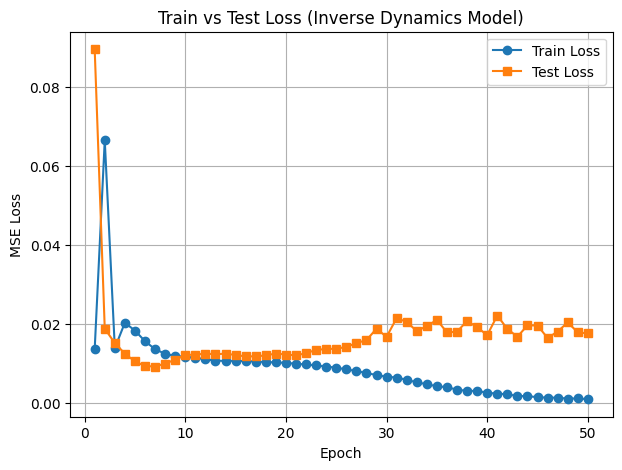

In [24]:
plt.figure(figsize=(7, 5))
plt.plot(epochs, train_losses, marker='o', label="Train Loss")
plt.plot(epochs, test_losses, marker='s', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train vs Test Loss (Inverse Dynamics Model)")
plt.legend()
plt.grid(True)
plt.show()


### Creating a comparision Dataframe of Ground truth and motion vector

In [26]:
model.eval()

with torch.no_grad():
    test_preds = model(X_test).numpy()
    test_gt = y_test.numpy()

In [27]:
df_compare = pd.DataFrame({
    "gt_dx": test_gt[:, 0],
    "gt_dy": test_gt[:, 1],
    "pred_dx": test_preds[:, 0],
    "pred_dy": test_preds[:, 1],
})

# compute errors
df_compare["err_dx"] = df_compare["pred_dx"] - df_compare["gt_dx"]
df_compare["err_dy"] = df_compare["pred_dy"] - df_compare["gt_dy"]
df_compare["l2_error"] = np.sqrt(
    df_compare["err_dx"]**2 + df_compare["err_dy"]**2
)
df_compare.tail(50)

,gt_dx,gt_dy,pred_dx,pred_dy,err_dx,err_dy,l2_error
0,-0.300547,-0.091987,-0.251911,-0.088689,0.048637,0.003299,0.048749
1,0.010672,0.003121,0.003048,0.008624,-0.007624,0.005503,0.009403
2,0.005865,-0.002353,0.012681,-0.004418,0.006816,-0.002065,0.007121
3,0.031652,0.020686,-0.097788,-0.052151,-0.129440,-0.072837,0.148526
4,0.004846,-0.018999,-0.017671,-0.046623,-0.022517,-0.027624,0.035639
5,-0.170236,-0.294381,0.037489,0.105936,0.207726,0.400317,0.451003
6,-0.003731,-0.005752,-0.033008,-0.014978,-0.029276,-0.009226,0.030696
7,-0.120956,-0.174292,0.006234,0.083807,0.127190,0.258099,0.287737
8,0.003344,-0.014618,-0.000921,-0.013921,-0.004265,0.000697,0.004322
9,-0.080305,-0.104345,0.081223,0.086988,0.161528,0.191333,0.250399


In [28]:
df_compare.describe()

,gt_dx,gt_dy,pred_dx,pred_dy,err_dx,err_dy,l2_error
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,-0.053474,-0.066337,-0.030841,-0.001403,0.022633,0.064934,0.126211
std,0.105406,0.095509,0.088518,0.067427,0.106042,0.149800,0.146165
min,-0.300547,-0.294381,-0.251911,-0.088689,-0.129440,-0.072837,0.004322
25%,-0.100630,-0.098166,-0.055817,-0.049387,-0.025897,-0.018425,0.020049
50%,0.003344,-0.018999,-0.000921,-0.013921,-0.004265,0.000697,0.048749
75%,0.008269,-0.004052,0.009457,0.046216,0.087913,0.098418,0.199463
max,0.031652,0.020686,0.081223,0.105936,0.207726,0.400317,0.451003


### Visualising the modtion

Image shape: (720, 1280, 3)


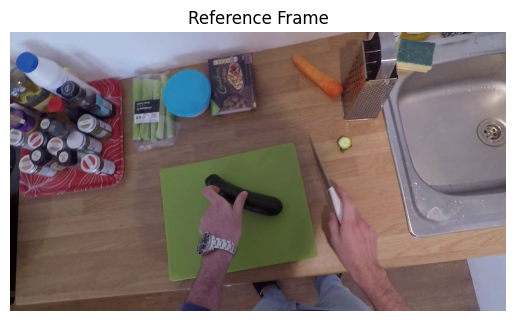

In [30]:
# get image filename from dataframe
idx = 8
row = df_test.iloc[idx]
img_name = row["img_t"] if "img_t" in row else comparison.index[idx]

frame_files = sorted([f for f in os.listdir(frame_dir) if f.endswith("_t.jpg")])
img_path = os.path.join(frame_dir, frame_files[idx])

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

h, w, _ = img.shape
print("Image shape:", img.shape)

plt.imshow(img)
plt.axis("off")
plt.title("Reference Frame")
plt.show()

In [31]:
gt_dx, gt_dy = y_test[idx]
with torch.no_grad():
    pred_dx, pred_dy = model(X_test[idx:idx+1]).numpy()[0]


# choose arrow start point (center of image)
cx, cy = w // 2, h // 2

# scale for visibility
scale = 1200

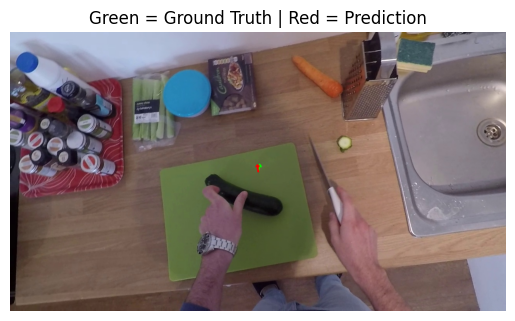

In [32]:
img_vis = img.copy()

# Ground truth arrow (green)
cv2.arrowedLine(
    img_vis,
    (cx, cy),
    (int(cx + gt_dx * scale), int(cy + gt_dy * scale)),
    (0, 255, 0),
    3,
    tipLength=0.3
)

# Predicted arrow (red)
cv2.arrowedLine(
    img_vis,
    (cx, cy),
    (int(cx + pred_dx * scale), int(cy + pred_dy * scale)),
    (255, 0, 0),
    3,
    tipLength=0.3
)

plt.imshow(img_vis)
plt.axis("off")
plt.title("Green = Ground Truth | Red = Prediction")
plt.show()

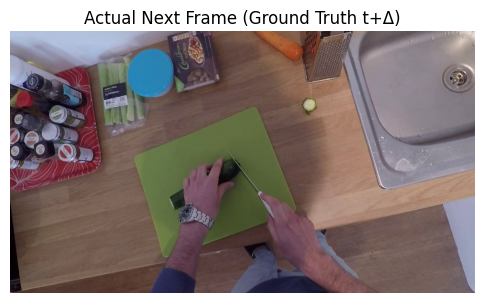

In [33]:
# show the actual next frame (t2)
img_next = cv2.imread(os.path.join(frame_dir, row["img_t2"]))
img_next = cv2.cvtColor(img_next, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6, 6))
plt.imshow(img_next)
plt.axis("off")
plt.title("Actual Next Frame (Ground Truth t+Δ)")
plt.show()


## Semantics

### Attaching verbs to pseudo action training and testing set so that we can predict action

In [40]:
def extract_action_idx(name):
    parts = name.split("_")
    for p in parts:
        if p.isdigit():
            return int(p)
    raise ValueError(f"No numeric action index found in filename: {name}")


# add action_idx
df_train["action_idx"] = df_train["img_t"].apply(extract_action_idx)
df_test["action_idx"]  = df_test["img_t"].apply(extract_action_idx)

# attach verb text using existing df (EPIC annotations)

df_train["verb"] = df_train["action_idx"].apply(
    lambda i: df.loc[i, "verb"]
)

df_test["verb"] = df_test["action_idx"].apply(
    lambda i: df.loc[i, "verb"]
)

# sanity check
df_train[["img_t", "verb"]].head()


,img_t,verb
8,112_2_t.jpg,put-down
49,89_6_t.jpg,take
6,100_6_t.jpg,take
47,89_4_t.jpg,take
4,100_4_t.jpg,take


In [41]:
# create verb vocabulary from TRAIN set only
unique_verbs = sorted(df_train["verb"].unique())

verb_to_id = {v: i for i, v in enumerate(unique_verbs)}
id_to_verb = {i: v for v, i in verb_to_id.items()}

# add verb_id column
df_train["verb_id"] = df_train["verb"].map(verb_to_id)
df_test["verb_id"]  = df_test["verb"].map(verb_to_id)

# sanity checks
print("Verb vocabulary:", verb_to_id)
df_train[["verb", "verb_id"]].head()


Verb vocabulary: {'close': 0, 'open': 1, 'put-down': 2, 'take': 3, 'turn-on': 4}


,verb,verb_id
8,put-down,2
49,take,3
6,take,3
47,take,3
4,take,3


### Upadting IDM so that we can predict Semantics 

In [43]:
class SInverseDynamicsModel(nn.Module):
    def __init__(self, num_verbs, verb_embed_dim=8):
        super().__init__()

        # SAME visual encoder as before
        self.features = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

        # verb embedding
        self.verb_embed = nn.Embedding(num_verbs, verb_embed_dim)
        self.head = nn.Sequential(
            nn.Linear(64 * 16 * 16 + verb_embed_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x_img, x_verb):
        # visual features
        v = self.features(x_img)
        v = v.reshape(v.size(0), -1)

        # semantic features
        e = self.verb_embed(x_verb)

        # fuse vision + verb
        fused = torch.cat([v, e], dim=1)

        return self.head(fused)


### Building Verb Tensors


In [45]:
# verb ids
X_train_verb = torch.tensor(df_train["verb_id"].values).long()
X_test_verb  = torch.tensor(df_test["verb_id"].values).long()
y_train = torch.tensor(df_train[["dx", "dy"]].values).float()
y_test  = torch.tensor(df_test[["dx", "dy"]].values).float()


In [46]:
print("X_train_img:", X_train.shape)
print("X_train_verb:", X_train_verb.shape)
print("y_train:", y_train.shape)


X_train_img: torch.Size([40, 6, 128, 128])
X_train_verb: torch.Size([40])
y_train: torch.Size([40, 2])


In [47]:
num_verbs = df_train["verb_id"].nunique()

model_semantic = SInverseDynamicsModel(
    num_verbs=num_verbs,
    verb_embed_dim=8
)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_semantic.parameters(), lr=1e-3)


In [48]:
model_semantic.eval()
with torch.no_grad():
    train_preds_before = model_semantic(X_train, X_train_verb)
    test_preds_before  = model_semantic(X_test, X_test_verb)

train_loss_before = criterion(train_preds_before, y_train).item()
test_loss_before  = criterion(test_preds_before, y_test).item()

print("Semantic model — BEFORE training")
print("Train loss:", round(train_loss_before, 5))
print("Test loss :", round(test_loss_before, 5))


Semantic model — BEFORE training
Train loss: 0.01526
Test loss : 0.00951


### Training the new model

In [50]:
epochs = 50
train_losses_sem = []
test_losses_sem = []

for epoch in range(epochs):
    
    model_semantic.train()
    optimizer.zero_grad()

    preds = model_semantic(X_train, X_train_verb)
    train_loss = criterion(preds, y_train)

    train_loss.backward()
    optimizer.step()

    model_semantic.eval()
    with torch.no_grad():
        test_preds = model_semantic(X_test, X_test_verb)
        test_loss = criterion(test_preds, y_test)

    train_losses_sem.append(train_loss.item())
    test_losses_sem.append(test_loss.item())

    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch {epoch+1:02d} | "
            f"Train Loss: {train_loss.item():.5f} | "
            f"Test Loss: {test_loss.item():.5f}"
        )


Epoch 10 | Train Loss: 0.01355 | Test Loss: 0.00966
Epoch 20 | Train Loss: 0.01078 | Test Loss: 0.01557
Epoch 30 | Train Loss: 0.00846 | Test Loss: 0.01734
Epoch 40 | Train Loss: 0.00610 | Test Loss: 0.02039
Epoch 50 | Train Loss: 0.00405 | Test Loss: 0.02552


### Visualisation

#### Loss Curve

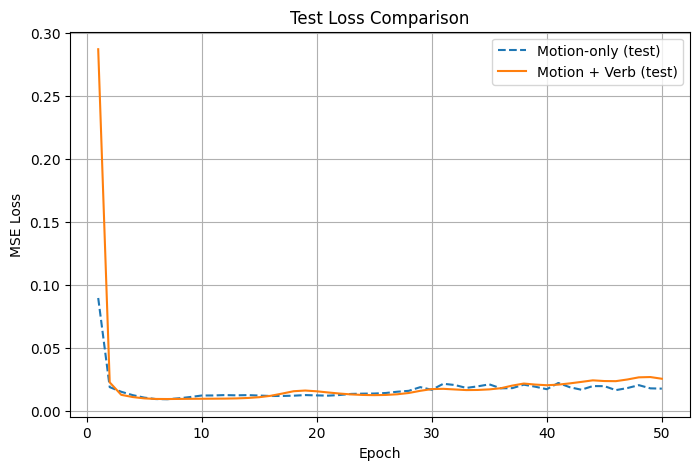

In [53]:
epochs = range(1, len(test_losses) + 1)

plt.figure(figsize=(8, 5))

# motion-only model
plt.plot(epochs, test_losses, label="Motion-only (test)", linestyle="--")

# semantic model
plt.plot(epochs, test_losses_sem, label="Motion + Verb (test)")

plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Test Loss Comparison")
plt.legend()
plt.grid(True)

plt.show()

In [54]:
row = df_test.iloc[8]

img = cv2.imread(os.path.join(frame_dir, row["img_t"]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# center of image
h, w, _ = img.shape
cx, cy = w // 2, h // 2


In [55]:
img_path = os.path.join(frame_dir, row["img_t"])
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

h, w, _ = img.shape
cx, cy = w // 2, h // 2
gt_dx = row["dx"]
gt_dy = row["dy"]
with torch.no_grad():
    pred_motion = model(X_test[idx:idx+1]).numpy()[0]
    pred_semantic = model_semantic(
        X_test[idx:idx+1],
        X_test_verb[idx:idx+1]
    ).numpy()[0]



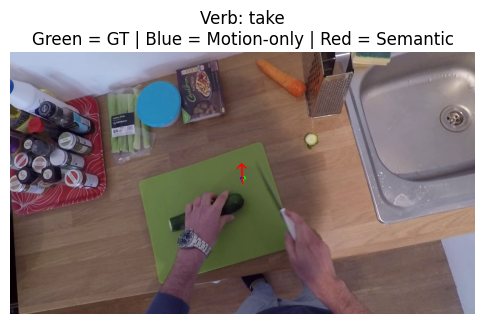

In [56]:
img_vis = img.copy()
scale = 1200  # adjust if arrows are too small / large

# Ground truth (green)
cv2.arrowedLine(
    img_vis,
    (cx, cy),
    (int(cx + gt_dx * scale), int(cy + gt_dy * scale)),
    (0, 255, 0),
    3,
    tipLength=0.3
)

# Motion-only prediction (blue)
cv2.arrowedLine(
    img_vis,
    (cx, cy),
    (int(cx + pred_motion[0] * scale), int(cy + pred_motion[1] * scale)),
    (0, 0, 255),
    3,
    tipLength=0.3
)

# Semantic prediction (red)
cv2.arrowedLine(
    img_vis,
    (cx, cy),
    (int(cx + pred_semantic[0] * scale), int(cy + pred_semantic[1] * scale)),
    (255, 0, 0),
    3,
    tipLength=0.3
)

plt.figure(figsize=(6, 6))
plt.imshow(img_vis)
plt.axis("off")
plt.title(
    f"Verb: {row['verb']}\n"
    "Green = GT | Blue = Motion-only | Red = Semantic"
)
plt.show()


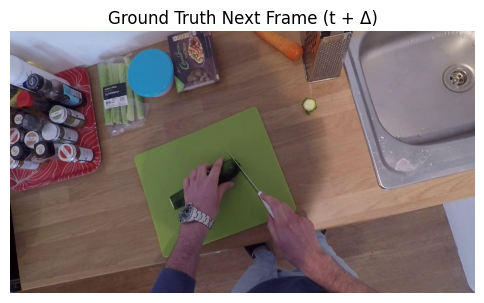

In [57]:
# load next frame (ground truth future)
img2_path = os.path.join(frame_dir, row["img_t2"])
img2 = cv2.imread(img2_path)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6, 6))
plt.imshow(img2)
plt.axis("off")
plt.title("Ground Truth Next Frame (t + Δ)")
plt.show()


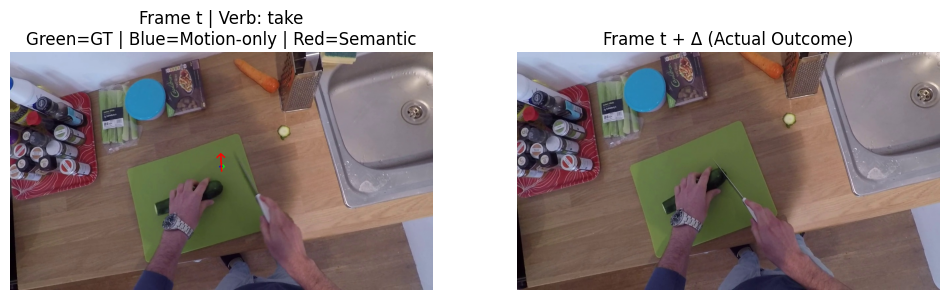

In [58]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_vis)
plt.axis("off")
plt.title(
    f"Frame t | Verb: {row['verb']}\n"
    "Green=GT | Blue=Motion-only | Red=Semantic"
)

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.axis("off")
plt.title("Frame t + Δ (Actual Outcome)")

plt.show()


### Implementing Horizontal Flip Augmentation

In [60]:
def horizontal_flip_image(img):
    # img: H x W x C
    return cv2.flip(img, 1) 


In [61]:
augmented_rows = []

frame_dir = r"C:\Users\hrush\OneDrive\Desktop\dataframes"
flip_dir  = os.path.join(frame_dir, "flipped")
os.makedirs(flip_dir, exist_ok=True)

for _, row in df_train.iterrows():
    img_t  = cv2.imread(os.path.join(frame_dir, row["img_t"]))
    img_t2 = cv2.imread(os.path.join(frame_dir, row["img_t2"]))

    if img_t is None or img_t2 is None:
        continue
    # FLIP
    img_t_flip  = horizontal_flip_image(img_t)
    img_t2_flip = horizontal_flip_image(img_t2)

    cv2.imwrite(os.path.join(flip_dir, row["img_t"]),  img_t_flip)
    cv2.imwrite(os.path.join(flip_dir, row["img_t2"]), img_t2_flip)

    augmented_rows.append({
        "img_t":  row["img_t"],
        "img_t2": row["img_t2"],
        "dx": -row["dx"],     
        "dy":  row["dy"],
        "verb": row["verb"]
    })

print("Flipped samples created:", len(augmented_rows))

Flipped samples created: 40


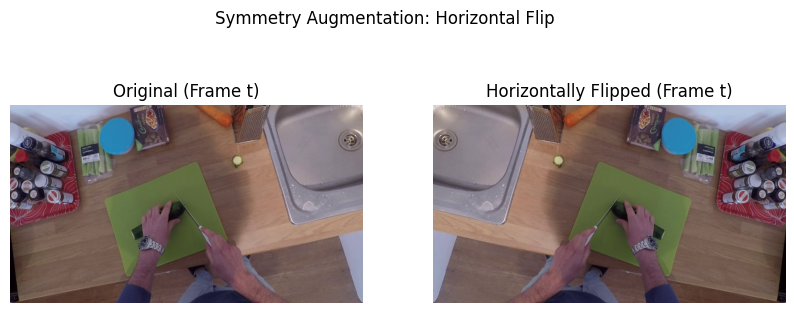

In [62]:
# use same idx as semantic example
idx = 8
row = df_train.iloc[idx]

# load original image (frame t)
img_orig = cv2.imread(os.path.join(frame_dir, row["img_t"]))
img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

# flip image (on-the-fly, no saving)
img_flip = horizontal_flip_image(img_orig)

# plot side-by-side
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_orig)
plt.title("Original (Frame t)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_flip)
plt.title("Horizontally Flipped (Frame t)")
plt.axis("off")

plt.suptitle("Symmetry Augmentation: Horizontal Flip")
plt.show()


### Trainging Dataset

In [64]:
df_train_aug = pd.concat(
    [df_train, pd.DataFrame(augmented_rows)],
    ignore_index=True
)

print("Original train samples :", len(df_train))
print("Augmented train samples:", len(df_train_aug))


Original train samples : 40
Augmented train samples: 80


In [65]:
df_train_aug["verb_encoded"] = df_train_aug["verb"].map(verb_to_id)
df_train_aug[["verb", "verb_encoded"]].head()

,verb,verb_encoded
0,put-down,2
1,take,3
2,take,3
3,take,3
4,take,3


In [66]:
X_train_aug = []
y_train_aug = []

for _, row in df_train_aug.iterrows():
    X_train_aug.append(load_image_pair(row))
    y_train_aug.append([row["dx"], row["dy"]])

X_train_aug = torch.tensor(X_train_aug).permute(0, 3, 1, 2).float()
y_train_aug = torch.tensor(y_train_aug).float()

print("X_train_aug:", X_train_aug.shape)
print("y_train_aug:", y_train_aug.shape)


X_train_aug: torch.Size([80, 6, 128, 128])
y_train_aug: torch.Size([80, 2])


C:\Users\hrush\AppData\Local\Temp\ipykernel_6876\2128360511.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  X_train_aug = torch.tensor(X_train_aug).permute(0, 3, 1, 2).float()


### Reinitializing The model

In [68]:
model_aug = InverseDynamicsModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_aug.parameters(), lr=1e-3)

In [69]:
model_aug.eval()
with torch.no_grad():
    train_preds_before = model_aug(X_train_aug)
    test_preds_before  = model_aug(X_test)

train_loss_before = criterion(train_preds_before, y_train_aug).item()
test_loss_before  = criterion(test_preds_before, y_test).item()

print("Augmented model — BEFORE training")
print("Train loss:", round(train_loss_before, 5))
print("Test  loss:", round(test_loss_before, 5))


Augmented model — BEFORE training
Train loss: 0.01311
Test  loss: 0.01857


In [70]:
epochs = 50
train_losses_aug = []
test_losses_aug = []

In [71]:
for epoch in range(epochs):
    # Training the model with Flipped Images
    model_aug.train()
    optimizer.zero_grad()

    preds_train = model_aug(X_train_aug)
    train_loss = criterion(preds_train, y_train_aug)

    train_loss.backward()
    optimizer.step()

    #Testing with the flipped image
    model_aug.eval()
    with torch.no_grad():
        preds_test = model_aug(X_test)
        test_loss = criterion(preds_test, y_test)

    train_losses_aug.append(train_loss.item())
    test_losses_aug.append(test_loss.item())

    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch {epoch+1:02d} | "
            f"Train Loss: {train_loss.item():.5f} | "
            f"Test Loss: {test_loss.item():.5f}"
        )

Epoch 10 | Train Loss: 0.01167 | Test Loss: 0.01359
Epoch 20 | Train Loss: 0.01072 | Test Loss: 0.01385
Epoch 30 | Train Loss: 0.00902 | Test Loss: 0.01841
Epoch 40 | Train Loss: 0.00872 | Test Loss: 0.01559
Epoch 50 | Train Loss: 0.00851 | Test Loss: 0.01653


## Visualisation

#### Plotting Loss curve

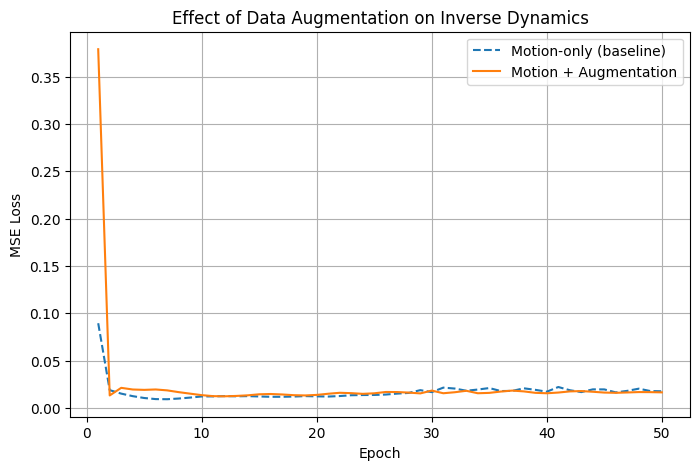

In [74]:
epochs = range(1, len(test_losses) + 1)

plt.figure(figsize=(8, 5))

plt.plot(epochs, test_losses, label="Motion-only (baseline)", linestyle="--")
plt.plot(epochs, test_losses_aug, label="Motion + Augmentation")

plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Effect of Data Augmentation on Inverse Dynamics")
plt.legend()
plt.grid(True)

plt.show()


In [75]:
print("Final Test Loss Comparison")
print("Motion-only baseline :", round(test_losses[-1], 5))
print("Motion + Augmentation:", round(test_losses_aug[-1], 5))


Final Test Loss Comparison
Motion-only baseline : 0.01768
Motion + Augmentation: 0.01653


In [76]:
row = df_test.iloc[8]

In [77]:
# frame t
img_t_path = os.path.join(frame_dir, row["img_t"])
img_t = cv2.imread(img_t_path)
img_t = cv2.cvtColor(img_t, cv2.COLOR_BGR2RGB)

# frame t+Δ
img_t2_path = os.path.join(frame_dir, row["img_t2"])
img_t2 = cv2.imread(img_t2_path)
img_t2 = cv2.cvtColor(img_t2, cv2.COLOR_BGR2RGB)

h, w, _ = img_t.shape
cx, cy = w // 2, h // 2


In [78]:
# frame t
img_t_path = os.path.join(frame_dir, row["img_t"])
img_t = cv2.imread(img_t_path)
img_t = cv2.cvtColor(img_t, cv2.COLOR_BGR2RGB)

# frame t+Δ
img_t2_path = os.path.join(frame_dir, row["img_t2"])
img_t2 = cv2.imread(img_t2_path)
img_t2 = cv2.cvtColor(img_t2, cv2.COLOR_BGR2RGB)

h, w, _ = img_t.shape
cx, cy = w // 2, h // 2


In [79]:
with torch.no_grad():
    pred_motion = model(X_test[idx:idx+1]).numpy()[0]
    pred_aug    = model_aug(X_test[idx:idx+1]).numpy()[0]
    pred_sem    = model_semantic(
        X_test[idx:idx+1],
        X_test_verb[idx:idx+1]
    ).numpy()[0]

pm_dx, pm_dy = pred_motion
pa_dx, pa_dy = pred_aug
ps_dx, ps_dy = pred_sem


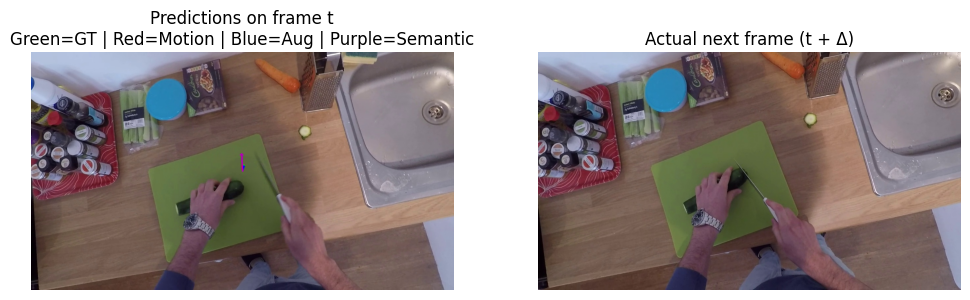

In [80]:
img_vis = img_t.copy()
scale = 1200

# Ground truth — GREEN
cv2.arrowedLine(img_vis, (cx, cy),
                (int(cx + gt_dx*scale), int(cy + gt_dy*scale)),
                (0,255,0), 3)

# Motion-only — RED
cv2.arrowedLine(img_vis, (cx, cy),
                (int(cx + pm_dx*scale), int(cy + pm_dy*scale)),
                (255,0,0), 3)

# Augmented — BLUE
cv2.arrowedLine(img_vis, (cx, cy),
                (int(cx + pa_dx*scale), int(cy + pa_dy*scale)),
                (0,0,255), 3)

# Semantic — PURPLE
cv2.arrowedLine(img_vis, (cx, cy),
                (int(cx + ps_dx*scale), int(cy + ps_dy*scale)),
                (180,0,180), 3)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_vis)
plt.title("Predictions on frame t\nGreen=GT | Red=Motion | Blue=Aug | Purple=Semantic")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_t2)
plt.title("Actual next frame (t + Δ)")
plt.axis("off")

plt.show()
